# Тестовое задание на позицию Аналитик данных - в коммерческий департамент
Исп.: Ю.В. Сулковская

Задание:\
На выходе требуется получить таблицу в формате .xlsx содержащую информацию о том, сколько цветомоделей (уникальных сцепок Article & Color), а также сколько товара в штуках должно поступить на склад в каждый из месяцев 2021 года, для каждой товарной категории в разбивке по цветам.

Препаки имеют по несколько дат прибытия на склад, но для расчета месяца необходимо учесть только первую дату прибытия.

Кол-во штук в заказе считается следующим образом: Order Pcs = Boxes quantity * Pcs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#изменяет формат графиков на png, для возможности отображения в GitHub.
#*необходим только для публикации. В рамках анализа лучше не использовать, для возможности просмотра точных цифр на графиках.
import plotly.io as pio
pio.renderers.default = 'png'

# Предобработка данных

Считаем таблицы с данными о товарах:

In [3]:
article_description = pd.read_csv("C:/Users/Julia/HEXProjects/datasets/clothes_store/article description.csv",sep = ';')

In [4]:
article_description.head()

,Article,Product Description
0,Art1,Trousers
1,Art2,Jeans
2,Art3,Dress
3,Art4,Trousers
4,Art5,Trousers


In [5]:
article_description.shape

(12999, 2)

Файл содержит описательную информацию о товарах:\
Article - номер артикула товара, по которому сформирован заказ\
Product Description - описание товара

In [6]:
prepack_description = pd.read_csv("C:/Users/Julia/HEXProjects/datasets/clothes_store/prepack description.csv", sep =';')

In [7]:
prepack_description.head()

,Prepack,Article,Color,Pcs
0,Prep1,Art1,red,4
1,Prep1,Art1,white,2
2,Prep1,Art1,pink,6
3,Prep2,Art2,red,2
4,Prep2,Art2,white,6


In [8]:
prepack_description.shape

(38997, 4)

Файл содержит информацию о наполнении каждого из препаков (сколько штук каждого цвета лежит в коробе):\
Prepack - номер препака\
Article - номер артикула товара, по которому сформирован заказ\
Color - цвет товара\
Pcs - кол-во штук в коробе для каждого цвета

Сгруппируем данные по цвету, препаку и продукту, а также посчитаем артикулы и просуммируем количество товара в коробке:

In [9]:
order_info = pd.read_csv("C:/Users/Julia/HEXProjects/datasets/clothes_store/order info.csv", sep =';', parse_dates=['ETA'], dayfirst=True)

In [10]:
order_info.head()

,Prepack,Boxes quantity,ETA
0,Prep1,19,2020-02-01
1,Prep1,50,2020-09-01
2,Prep2,45,2020-04-01
3,Prep2,22,2020-12-01
4,Prep3,9,2020-07-01


In [11]:
order_info.dtypes

Prepack                   object
Boxes quantity             int64
ETA               datetime64[ns]
dtype: object

In [12]:
order_info.shape

(28998, 3)

Файл содержит информацию о заказах препаков (коробов):\
Prepack - номер препака\
Boxes quantity - кол-во коробов в заказе\
ETA - дата прибытия заказа на склад

Отфильтруем только 2021 год:

In [13]:
order_info_2021 = order_info[order_info.ETA > '2020-12-01']

Выделим месяц из даты, учитывая, что месяц распологается в конце строки (как день):

In [14]:
order_info_2021['Month'] = order_info_2021.ETA.dt.month

C:\Users\Julia\AppData\Local\Temp\ipykernel_15036\3463843722.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
order_info_2021.head()

,Prepack,Boxes quantity,ETA,Month
19998,Prep10000,50,2021-01-01,1
19999,Prep10000,26,2021-04-01,4
20000,Prep10000,43,2021-08-01,8
20001,Prep10001,40,2021-03-01,3
20002,Prep10001,24,2021-06-01,6


Сгруппирум данные по препакам и выделим первый месяц:

In [16]:
prep_data = order_info_2021.groupby('Prepack',as_index = False)\
    .agg({'Month':'min','Boxes quantity':'sum'})

Удостоверимся, что месяцы выделены корректно:

In [17]:
prep_data['Month'].unique()

array([ 1,  3,  7,  5,  2,  6,  4,  8,  9, 10], dtype=int64)

# Расчеты

Для выполнения задания, смерджим данные об артикулах и препаках:

In [18]:
article_with_prepack = article_description.merge(prepack_description, on='Article', how='inner')

In [19]:
article_with_prepack.head()

,Article,Product Description,Prepack,Color,Pcs
0,Art1,Trousers,Prep1,red,4
1,Art1,Trousers,Prep1,white,2
2,Art1,Trousers,Prep1,pink,6
3,Art2,Jeans,Prep2,red,2
4,Art2,Jeans,Prep2,white,6


In [20]:
temp_df = article_with_prepack.groupby(['Color','Prepack','Product Description'],as_index=False)\
    .agg({'Article':'count', 'Pcs':'sum'})\
    .rename(columns={'Article':'Article_Color Count'})

In [21]:
temp_df.head()

,Color,Prepack,Product Description,Article_Color Count,Pcs
0,beige,Prep10,Trousers,1,4
1,beige,Prep100,Trousers,1,2
2,beige,Prep10001,Dress,1,6
3,beige,Prep10004,Trousers,1,2
4,beige,Prep10005,Jeans,1,4


In [22]:
all_data = temp_df.merge(prep_data, on='Prepack', how='inner')

Посчитаем количество штук в заказе:

In [23]:
all_data['Order Pcs'] = all_data['Pcs'] * all_data['Boxes quantity']

In [24]:
all_data.head()

,Color,Prepack,Product Description,Article_Color Count,Pcs,Month,Boxes quantity,Order Pcs
0,beige,Prep10001,Dress,1,6,3,111,666
1,blue,Prep10001,Dress,1,2,3,111,222
2,yellow,Prep10001,Dress,1,6,3,111,666
3,beige,Prep10004,Trousers,1,2,7,98,196
4,black,Prep10004,Trousers,1,2,7,98,196


Далее сгруппируем по продукту, цвету и месяцу, чтобы посчитать сумму количества артикулов и количество товара в заказах: 

In [25]:
all_data.groupby(['Product Description', 'Color', 'Month'], as_index=False)\
    .agg({'Order Pcs':'sum', 'Article_Color Count':'sum'})

,Product Description,Color,Month,Order Pcs,Article_Color Count
0,Dress,beige,1,9582,35
1,Dress,beige,2,11844,40
2,Dress,beige,3,14304,44
3,Dress,beige,4,7020,19
4,Dress,beige,5,6764,20
...,...,...,...,...,...
473,Trousers,yellow,6,6370,20
474,Trousers,yellow,7,4426,15
475,Trousers,yellow,8,1136,5
476,Trousers,yellow,9,1918,6


Выведем полученные данные в таблицу Excel для других пользователей:

In [26]:
all_data.to_excel(r'C:\Users\Julia\Desktop\mydata.xlsx', index= False)

# EDA

Дополнительно проведем анализ полученных данных на предмет, какой продукт, цвет самый популярный и в какой месяц 2021 года было куплено максимальное количество товаров.

Проанализируем вопрос о предпочетаемом покупателям продукте в 2021 году:

In [27]:
most_populoar_product = all_data.groupby(['Product Description'], as_index=False)\
    .agg({'Order Pcs':'sum'})\
    .sort_values('Order Pcs', ascending = False)

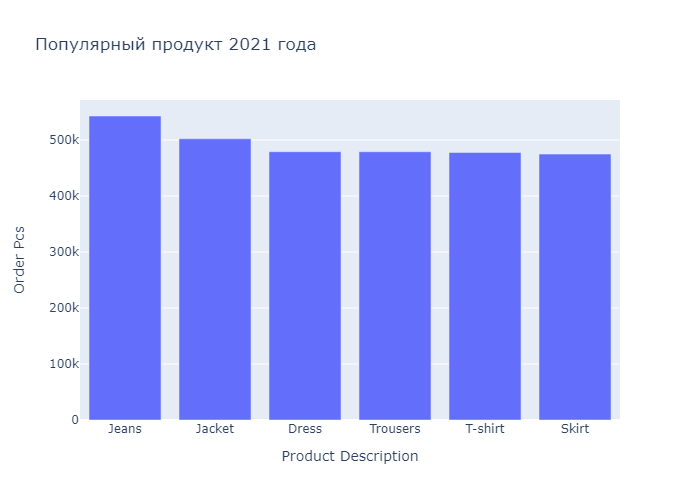

In [28]:
px.bar(most_populoar_product, x='Product Description', y='Order Pcs', title='Популярный продукт 2021 года')

Из данных графика установлено, что самым покупаемым продуктом нашего магазина являются Джинсы - 543 тыс. шт. за 2021 год.

Проанализируем вопрос о предпочетаемом покупателям цвете в 2021 году:

In [29]:
most_populoar_color = all_data.groupby(['Color'], as_index=False)\
    .agg({'Order Pcs':'sum'})\
    .sort_values('Order Pcs', ascending = False)\
    .rename(columns={'Order Pcs':'Order_Pcs'})

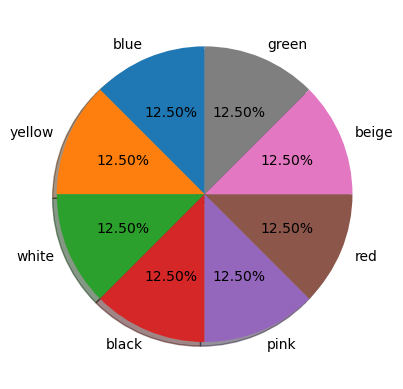

In [30]:
labels = most_populoar_color.Color.value_counts().index
sizes = most_populoar_color.Order_Pcs.value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%',shadow=True, startangle=90)
plt.show()

Из данных пайплота можно предположить, что все цвета занимают одинаковую долю на рынке - 12.5%.\
Попробуем построить другой график для более детальной оценки:

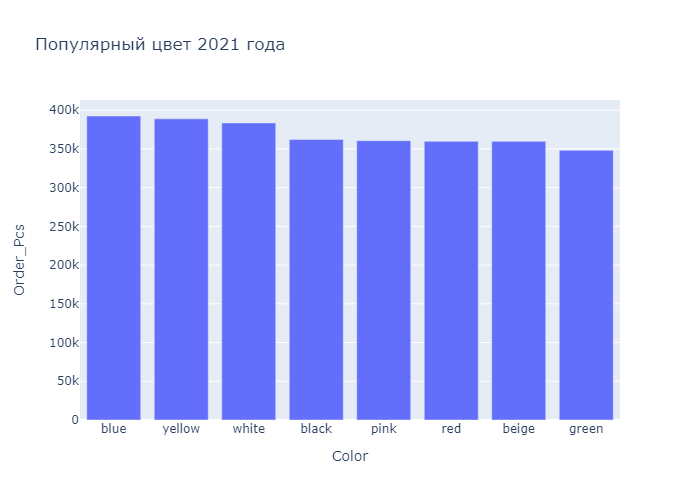

In [31]:
px.bar(most_populoar_color, x='Color', y='Order_Pcs', title='Популярный цвет 2021 года')

Из данных барчарта установлено, что, преимущественно, покупатели предпочитают синий цвет в одежде, в том числе из-за популярности Джинс - 393 тыс. шт. 

Проанализируем частоту покупок в Нашем магазине в 2021 году помесячно:

In [32]:
most_populoar_month = all_data.groupby(['Month'], as_index=False)\
    .agg({'Order Pcs':'sum'})\
    .sort_values('Month', ascending = True)

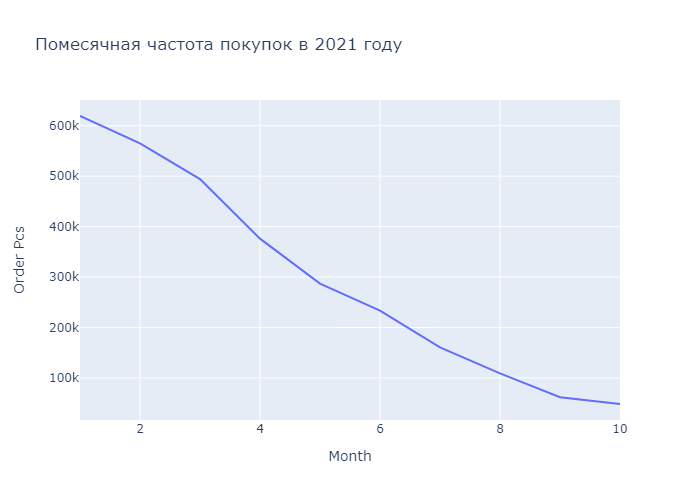

In [33]:
fig = px.line(most_populoar_month.reset_index(), x="Month", y="Order Pcs", title='Помесячная частота покупок в 2021 году')
fig.show() 

Из данных графика установлено, что к концу года продажи в магазине снижаются, но при этом в начале года зафиксирован самый высокий уровень спроса - 619 тыс. шт.